In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score

from catboost import CatBoostClassifier

import sys
sys.path.append("..")

from src.tcga_preprocess_utils import split_patients
from src.mofa_utils import train_mofa
from src.constants import RANDOM_STATE

In [2]:
combined_data = pd.read_csv('data/tsga_breast_kidney_for_mofa.csv')
combined_data

,Unnamed: 0,sample,feature,value,view,group
0,0,tcga.3c.aaau,ADAMTSL1|92949,0.105534,DNA,group_0
1,1,tcga.3c.aali,ADAMTSL1|92949,0.120799,DNA,group_0
2,2,tcga.3c.aalj,ADAMTSL1|92949,0.117392,DNA,group_0
3,3,tcga.3c.aalk,ADAMTSL1|92949,0.114669,DNA,group_0
4,4,tcga.4h.aaak,ADAMTSL1|92949,0.111725,DNA,group_0
...,...,...,...,...,...,...
1295738,34939,tcga.mm.a563,hsa-mir-203,0.127541,RNA,group_1
1295739,34940,tcga.mm.a564,hsa-mir-203,0.123825,RNA,group_1
1295740,34941,tcga.mm.a84u,hsa-mir-203,0.104273,RNA,group_1
1295741,34942,tcga.mw.a4ec,hsa-mir-203,0.125738,RNA,group_1


## 1. MOFA with default params

In [3]:
factors, weights, r2 = train_mofa(combined_data.copy(), RANDOM_STATE)
clear_output()

### Предсказание типа рака

Таргеты одинаковые для всех моделей - проверяем на одних и тех же пациентах

In [4]:
train_indices, test_indices, target = split_patients()

y_train, y_test = target[train_indices], target[test_indices]

In [6]:
X_train, X_test = factors[train_indices], factors[test_indices]

cb_classifier = CatBoostClassifier(n_estimators=5000, random_state=RANDOM_STATE, silent=True)
cb_classifier.fit(X_train, y_train)

y_pred = cb_classifier.predict(X_test)
y_probas = cb_classifier.predict_proba(X_test)

In [7]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probas[:, 1])

print(f'Accuracy: {accuracy}, F1: {f1}')

Accuracy: 0.9151785714285714, F1: 0.7956989247311829


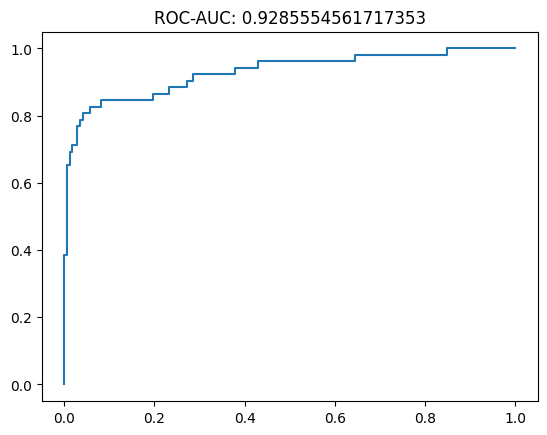

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas[:, 1])

plt.plot(fpr, tpr)
plt.title(f'ROC-AUC: {roc_auc}');

## 2. GridSearch по параметрам MOFA

In [9]:
params_grid = {
    'n_factors': range(10, 31, 10),
    'iter': range(1000, 5001, 1000),
    'tolerance': [None, 1e-2, 1e-3],
    'convergence_mode': ['slow', 'medium', 'fast']
}

In [ ]:
best_model = None
best_score = float('-inf')
best_params = None
results = []

for params in ParameterGrid(params_grid):
    train_params = {k: v for k, v in params.items() if k != 'n_factors'}

    factors_, weights_, r2_ = train_mofa(combined_data.copy(
    ), factors=params['n_factors'], random_state=RANDOM_STATE, train_params=train_params)

    clear_output()

    X_train_, X_test_ = factors_[train_indices], factors_[test_indices]

    score = float('-inf')
    try:
        cb_classifier.fit(X_train_, y_train)
        y_pred_ = cb_classifier.predict(X_test_)
        y_probas_ = cb_classifier.predict_proba(X_test_)
        roc_auc = roc_auc_score(y_test, y_probas_[:, 1])
        score = roc_auc

        print(params, score)
        results.append({'params': params, 'score': score})
        
    except Exception as e:
        print(e)

    if score > best_score:
        best_score = score
        best_params = params

grid_search_results = pd.DataFrame(columns=['Params', 'ROC AUC'])
grid_search_results['Params'] = list(map(lambda r: r['params'], results))
grid_search_results['ROC AUC'] = list(map(lambda r: r['score'], results))
grid_search_results.to_csv('mofa_grid_search.csv')

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

## 3. Результаты лучшей модели

In [11]:
best_params = {'convergence_mode': 'medium',
               'iter': 1000, 'n_factors': 10, 'tolerance': None}

best_train_params = {k: v for k, v in best_params.items() if k != 'n_factors'}

factors_best, weights_best, r2_best = train_mofa(combined_data.copy(
), factors=best_params['n_factors'], random_state=RANDOM_STATE, train_params=best_train_params)

clear_output()

In [12]:
X_train_best, X_test_best = factors_best[train_indices], factors_best[test_indices]

cb_classifier = CatBoostClassifier(n_estimators=5000, random_state=RANDOM_STATE, silent=True)
cb_classifier.fit(X_train_best, y_train)

y_pred = cb_classifier.predict(X_test_best)
y_probas = cb_classifier.predict_proba(X_test_best)

In [13]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probas[:, 1])

print(f'Accuracy: {accuracy}, F1: {f1}')

Accuracy: 0.9241071428571429, F1: 0.8172043010752689


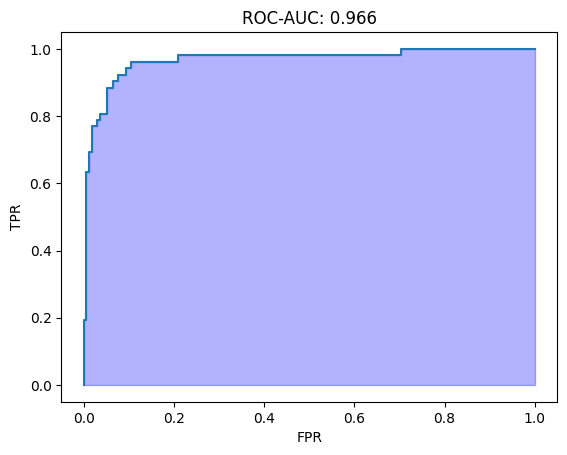

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas[:, 1])

plt.plot(fpr, tpr)
plt.title(f'ROC-AUC: {np.round(roc_auc, 3)}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.fill_between(fpr, tpr, color= "b", alpha=0.3);